In [2]:
from generate_dataset import generate_ds, generate_ds_class
generate_ds("train_20_10000.csv",20,ds_size=10000)
generate_ds_class("train_class_10000_20.csv",5,ds_size=10000)

In [1]:
import torch
from torch import optim, nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision import transforms as T
from torchvision import models, datasets
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from time import sleep

from utils import imshow, show_batch, show_image, show_image_pair, get_accuracy_bin
from models import ContrastiveLoss, EfficientSiemens, SiameseNetworkSimple, EfficientSiemensBinary, EfficientClassification
from generate_dataset import SiameseDataset, ClassificationDataset, TestingDatasetImageNet
from train import trainSiamens, trainBinary, trainClass

/Users/kristinanikolic/opt/anaconda3/envs/CV/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Define main data directory
DATA_DIR = 'tiny-imagenet-200-test' # Original images come in shapes of [3,64,64]

# Define training and validation data paths
TRAIN_DIR = os.path.join(DATA_DIR, 'train') 
VALID_DIR = os.path.join(DATA_DIR, 'val')

In [4]:
# Define device to use (CPU or GPU). CUDA = GPU support for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Using: " + str(device))

Using: cpu


In [5]:
# Define transformation sequence for image pre-processing
# If not using pre-trained model, normalize with 0.5, 0.5, 0.5 (mean and SD)
# If using pre-trained ImageNet, normalize with mean=[0.485, 0.456, 0.406], 
# std=[0.229, 0.224, 0.225])

preprocess_transform_pretrain = T.Compose([
                T.Resize(224), # Resize images to 256 x 256
                #T.CenterCrop(224), # Center crop image
                #T.RandomHorizontalFlip(),
                T.ToTensor(),  # Converting cropped images to tensors
                T.Normalize(mean=[0.485, 0.456, 0.406], 
                            std=[0.229, 0.224, 0.225])
])

simple = T.Compose([T.ToTensor(),  # Converting cropped images to tensors
])

In [6]:
train_data = SiameseDataset('train_20_10000.csv',TRAIN_DIR,preprocess_transform_pretrain)
batch_size = 128

if use_cuda:
    kwargs = {"pin_memory": True, "num_workers": 1}
else:
    kwargs = {}

# Wrap image dataset (defined above) in dataloader 
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, **kwargs)

generate_ds("val_20_2000.csv",20,ds_size=2000,val=True)
val_data = SiameseDataset('val_20_2000.csv',TRAIN_DIR,preprocess_transform_pretrain)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False, **kwargs)

# generate_ds("test_20_2000.csv",20,ds_size=2000)
# test_data = SiameseDataset('test_20_2000.csv',VALID_DIR,preprocess_transform_pretrain, val=True)
# test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, **kwargs)


In [7]:
# Setup function to create dataloaders for image datasets
def generate_dataloader(data, name, transform=None):
    if data is None: 
        return None
    
    # Read image files to pytorch dataset using ImageFolder, a generic data 
    # loader where images are in format root/label/filename
    # See https://pytorch.org/vision/stable/datasets.html
    if transform is None:
        dataset = datasets.ImageFolder(data, transform=T.ToTensor())
    else:
        dataset = datasets.ImageFolder(data, transform=transform)

    # Set options for device
    if use_cuda:
        kwargs = {"pin_memory": True, "num_workers": 1}
    else:
        kwargs = {}
    
    # Wrap image dataset (defined above) in dataloader 
    dataloader = DataLoader(dataset, batch_size=batch_size, 
                        shuffle=(name=="train"), 
                        **kwargs)
    
    return dataloader

In [9]:
val_img_dir = os.path.join(VALID_DIR, 'images')
test_loader= generate_dataloader(val_img_dir, "val",preprocess_transform_pretrain)

In [11]:
test_data = TestingDatasetImageNet(test_loader,preprocess_transform_pretrain)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, **kwargs)

In [15]:
show_image_pair(test_dataloader)

AttributeError: 'DataLoader' object has no attribute 'imgs'

In [ ]:
#train the model
def trainSiamenss(net, tresholds, epochs, train_dataloader, device, optimizer, criterion, sch):
    print(net)
    loss=[] 
    counter=[]
    acc = np.zeros([len(tresholds),epochs])
    iteration_number = 0
    for epoch in range(1,epochs):
        acc_ep = np.zeros(len(tresholds))
        items = 0
        batch = 0
        generate_ds("train_20_10000.csv",20,ds_size=10000)
        train_data = SiameseDataset('train_20_10000.csv',TRAIN_DIR,preprocess_transform_pretrain)
        train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, **kwargs)
        for batch_id, smpl in enumerate(tqdm(train_dataloader)):
            sleep(0.1)
            img0, img1, label = smpl[0], smpl[1], smpl[2]
            img0, img1, label = img0.to(device), img1.to(device) , label.to(device)
            optimizer.zero_grad()
            output1,output2 = net(img0,img1)
            loss_contrastive = criterion(output1,output2,label)
            loss_contrastive.backward()
            optimizer.step()
            euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)
            for m in range(len(tresholds)):
                label_t = euclidean_distance<tresholds[m]
                acc_ep[m] = accuracy_score(label, label_t)*len(label) + acc_ep[m]
            items = items + len(label)
            batch = batch + 1
        print("Epoch {}\n Current loss {}".format(epoch,loss_contrastive.item()))
        for m in range(len(tresholds)):
            print("Current accuracy {} for {}\n".format(acc_ep[m]/items,tresholds[m]))
            acc[m][epoch] = acc_ep[m]/items
        iteration_number += 1
        counter.append(iteration_number)
        loss.append(loss_contrastive.item())
        sch.step()
    plt.plot(counter, loss, label='Loss') 
    for m in range(len(tresholds)):
        plt.plot(counter, acc, label=str(tresholds[m]))
    plt.legend()
    return net

In [ ]:
#show_image(train_dataloader)

In [10]:
# Declare Siamese Network
net = EfficientSiemens(30)
net = net.to(device)
# Decalre Loss Function
criterion = ContrastiveLoss()
criterionB = nn.BCEWithLogitsLoss()
criterionC = nn.CrossEntropyLoss()
# Declare Optimizer
optimizer = optim.Adam(net.parameters(), lr=0.0005, weight_decay=False)
sch = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# Epochs
epochs = 6
tresholds = [0.75, 1.0, 1.25, 1.5]

INIT
38430


In [24]:
def test(net, tresholds, test_dataloader, device, criterion):
    net.eval()
    acc_v = np.zeros(len(tresholds))
    items = 0
    batch = 0
    for batch_id, smpl in enumerate(tqdm(test_dataloader)):
        sleep(0.1)
        img0, img1, label = smpl[0], smpl[1], smpl[2]
        img0, img1, label = img0.to(device), img1.to(device) , label.to(device)
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)
        for m in range(len(tresholds)):
            label_t = euclidean_distance<tresholds[m]
            acc_v[m] = accuracy_score(label, label_t)*len(label) + acc_v[m]
        items = items + len(label)
        batch = batch + 1
    print("Test loss {}".format(loss_contrastive.item()))
    for m in range(len(tresholds)):
        print("Test accuracy {} for {}\n".format(acc_v[m]/items,tresholds[m]))

In [25]:
test(model, tresholds=tresholds, test_dataloader=test_dataloader, device=device, criterion=criterion)


  0%|          | 0/16 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'tiny-imagenet-200-test/val/images/n07873807/n07873807_69.JPEG'

100%|██████████| 79/79 [10:46<00:00,  8.19s/it]


Epoch 0
 Current loss 0.43882766366004944
Current accuracy 0.5058505850585059 for 0.75

Current accuracy 0.5444544454445445 for 1.0

Current accuracy 0.5994599459945995 for 1.25

Current accuracy 0.5766576657665766 for 1.5



100%|██████████| 16/16 [01:52<00:00,  7.00s/it]


Epoch 0
 Current val loss 0.3854057788848877
Current val accuracy 0.5402701350675337 for 0.75

Current val accuracy 0.6843421710855427 for 1.0

Current val accuracy 0.6703351675837919 for 1.25

Current val accuracy 0.5742871435717859 for 1.5



100%|██████████| 79/79 [10:49<00:00,  8.23s/it]


Epoch 1
 Current loss 0.4775469899177551
Current accuracy 0.5212521252125213 for 0.75

Current accuracy 0.6548654865486548 for 1.0

Current accuracy 0.756975697569757 for 1.25

Current accuracy 0.6733673367336733 for 1.5



100%|██████████| 16/16 [01:56<00:00,  7.26s/it]


Epoch 1
 Current val loss 0.3324056565761566
Current val accuracy 0.6048024012006002 for 0.75

Current val accuracy 0.7593796898449224 for 1.0

Current val accuracy 0.7393696848424212 for 1.25

Current val accuracy 0.6338169084542271 for 1.5



100%|██████████| 79/79 [10:24<00:00,  7.91s/it]


Epoch 2
 Current loss 0.32916396856307983
Current accuracy 0.5533553355335533 for 0.75

Current accuracy 0.7438743874387439 for 1.0

Current accuracy 0.8068806880688069 for 1.25

Current accuracy 0.7056705670567057 for 1.5



100%|██████████| 16/16 [01:47<00:00,  6.69s/it]


Epoch 2
 Current val loss 0.2936968207359314
Current val accuracy 0.639319659829915 for 0.75

Current val accuracy 0.7968984492246123 for 1.0

Current val accuracy 0.7763881940970485 for 1.25

Current val accuracy 0.6658329164582291 for 1.5



100%|██████████| 79/79 [10:24<00:00,  7.91s/it]


Epoch 3
 Current loss 0.3829566538333893
Current accuracy 0.5903590359035904 for 0.75

Current accuracy 0.7873787378737874 for 1.0

Current accuracy 0.824982498249825 for 1.25

Current accuracy 0.7211721172117211 for 1.5



100%|██████████| 16/16 [02:03<00:00,  7.74s/it]


Epoch 3
 Current val loss 0.27358391880989075
Current val accuracy 0.6653326663331666 for 0.75

Current val accuracy 0.8029014507253627 for 1.0

Current val accuracy 0.7873936968484242 for 1.25

Current val accuracy 0.6948474237118559 for 1.5



100%|██████████| 79/79 [12:12<00:00,  9.27s/it]


Epoch 4
 Current loss 0.2945871651172638
Current accuracy 0.6279627962796279 for 0.75

Current accuracy 0.8162816281628162 for 1.0

Current accuracy 0.8315831583158316 for 1.25

Current accuracy 0.7294729472947294 for 1.5



100%|██████████| 16/16 [02:15<00:00,  8.46s/it]


Epoch 4
 Current val loss 0.27149146795272827
Current val accuracy 0.6928464232116058 for 0.75

Current val accuracy 0.8159079539769885 for 1.0

Current val accuracy 0.7923961980990495 for 1.25

Current val accuracy 0.6933466733366683 for 1.5



100%|██████████| 79/79 [13:17<00:00, 10.10s/it]


Epoch 5
 Current loss 0.3475686311721802
Current accuracy 0.6557655765576558 for 0.75

Current accuracy 0.8454845484548454 for 1.0

Current accuracy 0.8508850885088509 for 1.25

Current accuracy 0.7427742774277428 for 1.5



100%|██████████| 16/16 [02:27<00:00,  9.21s/it]


Epoch 5
 Current val loss 0.27011603116989136
Current val accuracy 0.6948474237118559 for 0.75

Current val accuracy 0.8204102051025512 for 1.0

Current val accuracy 0.7963981990995498 for 1.25

Current val accuracy 0.6873436718359179 for 1.5



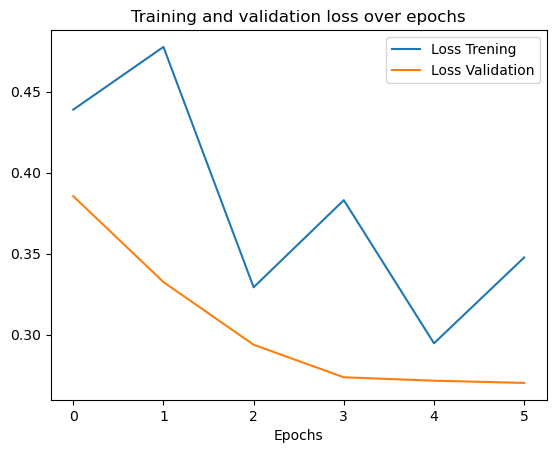

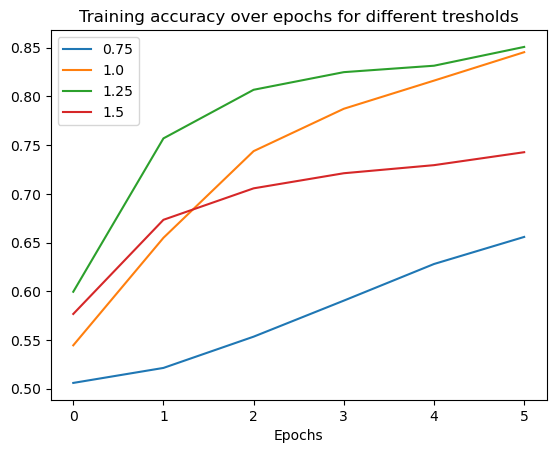

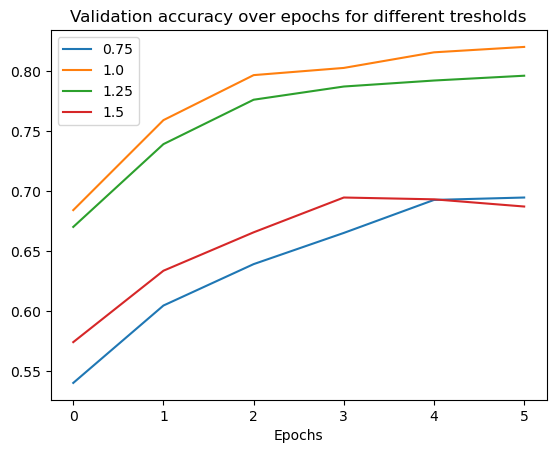

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


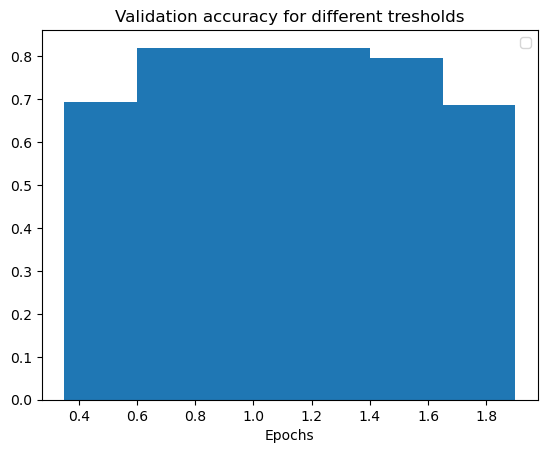

Model Saved Successfully


In [11]:
#train the model
def trainSiamens1(net, tresholds, epochs, train_dataloader, device, optimizer, criterion, sch, val_dataloader):
    loss=[] 
    loss_v=[]
    counter=[]
    counter_v=[]
    early_stop = 0
    acc = np.zeros([len(tresholds),epochs])
    f1 = np.zeros([len(tresholds),epochs])
    acc_val = np.zeros([len(tresholds),epochs])
    acc_test = np.zeros([len(tresholds),1])
    iteration_number = 0
    iteration_number_v = 0
    for epoch in range(0,epochs):
        acc_ep = np.zeros(len(tresholds))
        f1_ep = np.zeros(len(tresholds))
        items = 0
        batch = 0
        net.train()
        for batch_id, smpl in enumerate(tqdm(train_dataloader)):
            sleep(0.1)
            img0, img1, label = smpl[0], smpl[1], smpl[2]
            img0, img1, label = img0.to(device), img1.to(device) , label.to(device)
            optimizer.zero_grad()
            output1,output2 = net(img0,img1)
            loss_contrastive = criterion(output1,output2,label)
            loss_contrastive.backward()
            optimizer.step()
            euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)
            for m in range(len(tresholds)):
                label_t = euclidean_distance<tresholds[m]
                acc_ep[m] = accuracy_score(label, label_t)*len(label) + acc_ep[m]
            items = items + len(label)
            batch = batch + 1
        print("Epoch {}\n Current loss {}".format(epoch,loss_contrastive.item()))
        for m in range(len(tresholds)):
            print("Current accuracy {} for {}\n".format(acc_ep[m]/items,tresholds[m]))
            acc[m][epoch] = acc_ep[m]/items
        iteration_number += 1
        counter.append(epoch)
        loss.append(loss_contrastive.item())
        sch.step()

        net.eval()
        acc_v = np.zeros(len(tresholds))
        items = 0
        batch = 0
        for batch_id, smpl in enumerate(tqdm(val_dataloader)):
            sleep(0.1)
            img0, img1, label = smpl[0], smpl[1], smpl[2]
            img0, img1, label = img0.to(device), img1.to(device) , label.to(device)
            output1,output2 = net(img0,img1)
            loss_contrastive = criterion(output1,output2,label)
            euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)
            for m in range(len(tresholds)):
                label_t = euclidean_distance<tresholds[m]
                acc_v[m] = accuracy_score(label, label_t)*len(label) + acc_v[m]
            items = items + len(label)
            batch = batch + 1
        print("Epoch {}\n Current val loss {}".format(epoch,loss_contrastive.item()))
        for m in range(len(tresholds)):
            print("Current val accuracy {} for {}\n".format(acc_v[m]/items,tresholds[m]))
            acc_val[m][epoch] = acc_v[m]/items
        iteration_number_v += 1
        counter_v.append(epoch)
        if(not epoch==0 and loss_v[-1]<loss_contrastive.item()):
            early_stop = early_stop + 1
        else:
            early_stop = 0
        loss_v.append(loss_contrastive.item())
        
        if early_stop>=3:
            break

    plt.Figure()
    plt.plot(counter, loss, label='Loss Trening') 
    plt.plot(counter_v, loss_v, label='Loss Validation') 
    plt.title("Training and validation loss over epochs")
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

    plt.Figure()
    for m in range(len(tresholds)):
        plt.plot(counter, acc[m][0:len(counter)], label=str(tresholds[m]))
    plt.title("Training accuracy over epochs for different tresholds")
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

    plt.Figure()
    for m in range(len(tresholds)):
        plt.plot(counter_v, acc_val[m][0:len(counter_v)], label=str(tresholds[m]))
    plt.title("Validation accuracy over epochs for different tresholds")
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

    plt.Figure()
    plt.bar(tresholds, acc_val[:,len(counter)-1])
    plt.title("Validation accuracy for different tresholds")
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

    return net

In [ ]:
plt.Figure()
#plt.plot(counter, loss, label='Loss') 
for m in range(1):
    plt.plot([32,2], [2,2], label=str(1))
plt.legend()
plt.show()

plt.Figure()
#plt.plot(counter_v, loss_v, label='Loss Val') 
for m in range(1):
    plt.plot([3,2], [2,2], label=str(1))
plt.legend()
plt.show()

plt.bar([1,2,3],[2,4,5])